## Training a model to classify Bill Clinton in audio recordings


In [1]:
import attk
import os
import csv
import numpy as np
import librosa
import timeit
import random
import subprocess
import urllib2
from sklearn.externals import joblib
from numpy import ma
from aubio import source, pitch
from moviepy.audio.io import AudioFileClip
from IPython.display import display, Audio

os.chdir('/sharedfolder/sida_classifier/')

class_list = ['Bill Clinton', 'Male', 'Female']

class_0_label, class_1_label, class_2_label = class_list

In [3]:
## SM: What is the bottom two lines on this one? Should we just delete those? 
## SM: I had to comment out the males_5k and females_5k because they didn't process MFCCs in the previous notebook.
## Load saved features

def load_features(dir_path):
    features = []
    for filename in os.listdir(dir_path):
        with open(os.path.join(dir_path, filename)) as fi:
            csv_reader = csv.reader(fi)
            for row in csv_reader:
                features.append([float(item) for item in row])
    return features

class_0_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Bill_Clinton/_vowel_mfccs_and_deltas')
print(len(class_0_features))

class_1_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Male_AAPB_171110/_vowel_mfccs_and_deltas')
#class_1_features += load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/males_5k/_vowel_mfccs_and_deltas')
print(len(class_1_features))

class_2_features = load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/Female_AAPB_171110/_vowel_mfccs_and_deltas')
#class_2_features += load_features('/sharedfolder/sida_classifier/_classes_Bill_Clinton/females_5k/_vowel_mfccs_and_deltas')
print(len(class_2_features))


## Downsampling each class to the size of the smallest in the set

min_length = np.min([len(class_0_features), len(class_1_features), len(class_2_features)])

try: class_0_features = random.sample(class_0_features, min_length)
except: pass
try: class_1_features = random.sample(class_1_features, min_length)
except: pass
try: class_2_features = random.sample(class_2_features, min_length)
except: pass

#aapb_ubm_male_features = load_features('/sharedfolder/sida_classifier/AAPB_male_vowel_mfccs_and_deltas_100-5K_Hz')
#print(len(aapb_ubm_male_features))

#aapb_ubm_female_features = load_features('/sharedfolder/sida_classifier/AAPB_female_vowel_mfccs_and_deltas_100-5K_Hz')
#print(len(aapb_ubm_female_features))

57
296
165


In [4]:
## Printing MFCCs and deltas for a single frame

print(random.choice(class_0_features))

[149.19108380966347, -28.58421507942724, 10.298442544990163, 7.21756598652935, 11.151894721655657, 0.14916709774155912, 20.815352426998476, -15.476612444630689, 7.891468515434858, -2.4615482673399605, 23.7857899347965, 6.7528479842485565, 12.243604688377843, 3.896913081775751, -8.15566385758964, 18.020987421605255, 6.900648195505434, -8.426059606004998, 2.8072637499100423, -1.008164974996049, 10.760900747119234, 3.802112836263942, -4.464472491311094, 7.782790610648679, -2.2109381205165146, -8.616176645187497, 12.277305257238924, -1.5480487718207678, 7.231685099875046, -13.389116339500031, 3.4098298647202894, 6.886789860048185, 2.095620777919766, -1.66489043245502, -3.2988994336118647, 0.0078121598351546875, 1.5792663357654009, 3.2202526922459116, -1.411940277185777, 1.262370462081057, 1.9099137030566407, -2.0979790918931602, 0.5217540849923077, 4.50375271787818, -0.1929909671813215, -3.3170834524178257, -0.013804136014146118, 2.6374149364896544, -0.2618672073765482, -0.8433283845649682

In [5]:
## Training and multi-layer perceptron model with 9/10 of training data 
# and evaluating performance on remaining 1/10

os.chdir('/sharedfolder/sida_classifier/')

import random

from sklearn.neural_network import MLPClassifier

X = class_0_features[:-len(class_0_features)/10] + \
    class_1_features[:-len(class_1_features)/10] + \
    class_2_features[:-len(class_2_features)/10]

y = [1]*len(class_0_features[:-len(class_0_features)/10]) + \
    [0]*len(class_1_features[:-len(class_1_features)/10]) + \
    [2]*len(class_2_features[:-len(class_2_features)/10])

X_train = np.array(X)
y_train = np.array(y)

X_test = class_0_features[-len(class_0_features)/10:] + class_1_features[-len(class_1_features)/10:] + \
    class_2_features[-len(class_2_features)/10:]
y_test = [1]*len(class_0_features[-len(class_0_features)/10:]) + \
    [0]*len(class_1_features[-len(class_1_features)/10:]) + \
    [2]*len(class_2_features[-len(class_2_features)/10:])

X_test = np.array(X_test)
y_test = np.array(y_test)
    
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

classifier = MLPClassifier(max_iter = 2000, random_state = 9, \
                          hidden_layer_sizes = (100, 100), solver = 'adam', \
                          activation = 'relu').fit(X_train_scaled, y_train)

print(classifier.score(X_test_scaled,y_test))

0.9444444444444444


In [6]:
## Training and saving MLPC model and scaler with all training data

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

X = class_0_features + class_1_features + class_2_features
y = [0]*len(class_0_features) + [1]*len(class_1_features) + [2]*len(class_2_features) 

scaler = StandardScaler()

scaler.fit(X)

StandardScaler(copy=True, with_mean=True, with_std=True)

X_scaled = scaler.transform(X)

#classifier = MLPClassifier().fit(X_scaled, y)

classifier = MLPClassifier(max_iter = 2000, random_state = 9, \
                          hidden_layer_sizes = (100, 100), solver = 'adam', \
                          activation = 'relu').fit(X_scaled, y)

trained_model_filename = 'BC' + '_vowels_mlpc_4096_100-16K_scaled_171116.pkl'
scaler_filename = trained_model_filename.replace('.pkl', '.scaler')

print(trained_model_filename)
print(scaler_filename)

## Saving trained model
joblib.dump(classifier, trained_model_filename)
joblib.dump(scaler, scaler_filename)
classifier = joblib.load(trained_model_filename)
scaler = joblib.load(scaler_filename)

BC_vowels_mlpc_4096_100-16K_scaled_171116.pkl
BC_vowels_mlpc_4096_100-16K_scaled_171116.scaler


In [ ]:
##############################################
#### Start here to load pre-trained model ####
##############################################

## If you have previously trained classifier and scaler models and 
# wish to skip the steps above, uncomment the commands below and 
# begin from this cell to load them.

#os.chdir('/sharedfolder/sida_classifier/')

#classifier = joblib.load(trained_model_filename)
#scaler = joblib.load(scaler_filename)

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.datasets.samples_generator import make_blobs

from pandas.tools.plotting import parallel_coordinates

In [8]:
## Flattening data to 2 dimensions with linear discriminant analysis (LDA) for visualization

lda = LDA(n_components=2) #2-dimensional LDA
lda_transformed = pd.DataFrame(lda.fit_transform(X_scaled, y))
lda_transformed.tail()

,0,1
166,1.301316,14.224881
167,0.330204,13.142655
168,1.085170,15.705728
169,0.778024,14.626728
170,0.346849,15.599680


In [9]:
lda_transformed['y'] = y

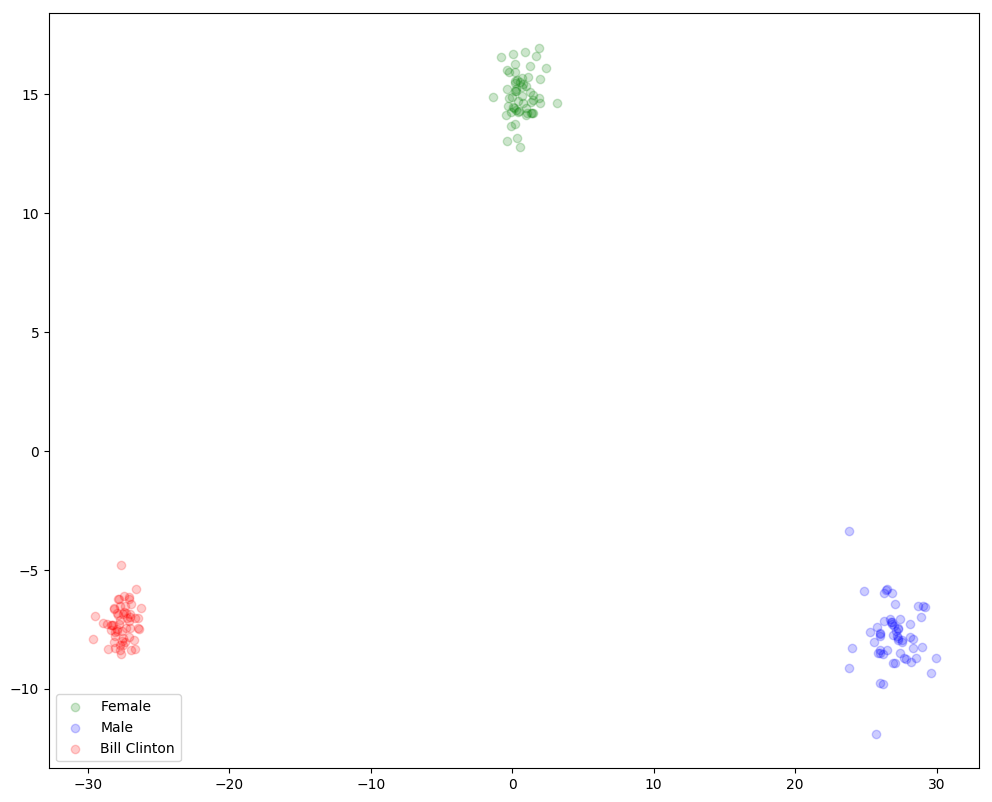

In [10]:
# 30 mfccs, 81

plt.figure(figsize=(12, 10), dpi=100)

plt.scatter(lda_transformed[lda_transformed['y']==2][0], lda_transformed[lda_transformed['y']==2][1], label='Female', c='green', alpha=0.2)
plt.scatter(lda_transformed[lda_transformed['y']==1][0], lda_transformed[lda_transformed['y']==1][1], label='Male', c='blue', alpha=0.2)

#plt.scatter(lda_transformed[lda_transformed['y']==3][0], lda_transformed[lda_transformed['y']==3][1], label='Music', c='orange', alpha=0.2)
plt.scatter(lda_transformed[lda_transformed['y']==0][0], lda_transformed[lda_transformed['y']==0][1], label='Bill Clinton', c='red', alpha=0.2)


plt.legend(loc=3)
plt.show()

In [11]:
def most_common_class(class_ids):
    mode_id = int(list(scipy.stats.mode(class_ids))[0][0])
    mode_id_percentage = float(float(class_ids.count(mode_id))/len(class_ids))
    return (mode_id, mode_id_percentage)

1. Create the directory /sharedfolder/sida_classifier/test_clips/
2. Move an "unseen" file (something that was not in the test corpus) into this directory. We've chosen an interview between Peter Jennnings and Bill Clinton (31:29): /sharedfolder/sida_classifier/test_clips/Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav

In [ ]:
## Download unseen audio 
!youtube-dl --extract-audio --audio-format wav https://www.youtube.com/watch?v=SS8reX-i8j4

In [26]:
#%%capture
## Split audio into 3-second WAV clips for testing
# if this doesn't work, try the following for the last line: !ffmpeg -i $wav_filename -c copy -map 0 -segment_time 3 -f segment $wav_filename%03d.wav

clip_path = '/sharedfolder/sida_classifier/test_clips/'

os.chdir(clip_path)

wav_filename = 'Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav'

#wav_filename = mp3_filename[:-4]+'.wav'

#subprocess.call(['ffmpeg', '-i', mp3_filename, wav_filename])

subprocess.call(['ffmpeg', '-i', wav_filename, '-f', 'segment', '-segment_time', '3',  wav_filename[:-4] + '_3_sec_%04d.wav'])

0

In [27]:
#SM: Can you add more here about how one should use this information? There is mostly a lot of "male" 
# and I only got one "Bill Clinton" even though I ran it about 20 times. 
## Classifying short clips
#### Repeat this cell several times to help choose a classifier threshold value.

import scipy

os.chdir('/sharedfolder/sida_classifier/test_clips/')

wav_pathname = os.path.abspath(random.choice([item for item in os.listdir('./') if '3_sec' in item]))

test_features = np.array(attk.get_mfccs_and_deltas(wav_pathname, n_mfcc=30, n_fft=8192))
test_features = scaler.transform(test_features)

print(wav_pathname)

results = classifier.predict(test_features)  ## Predicting new observation
results_proba = classifier.predict_proba(test_features)  ## Predicting new observation

print(results)
print([round(max(item), 4) for item in list(results_proba)])

vowel_results=[]

vowel_bools = attk.get_vowel_segments(wav_pathname, n_fft=8192)

for i in range(len(results)):
    if vowel_bools[i]==True:
        vowel_results.append(results[i])

display(Audio(wav_pathname))

print("MODE: " + str(list(scipy.stats.mode(results))[0][0])) 
print("MODE vowels only: " + str(list(scipy.stats.mode(vowel_results))[0][0])) ## Vowels only
#print("All samples: "+str(np.mean(results)))
#print("Vowels only: "+str(np.mean(vowel_results)))

mode_id, mode_id_percentage = most_common_class(vowel_results)
top_label = class_list[mode_id]

print('')
print("Speaker: " + str(top_label))
print("Confidence: " + str(mode_id_percentage))

print('')

print(str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')

/sharedfolder/sida_classifier/test_clips/Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4_3_sec_0263.wav
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.9579, 0.8181, 0.6487, 0.8309, 0.8376, 0.814, 0.8164, 0.9446, 0.9937, 0.9223, 0.9626, 0.9674, 0.9294, 0.9662, 0.9242, 0.699, 0.7194]


MODE: 1
MODE vowels only: 1

Speaker: Male
Confidence: 1.0

1,1.0,Male



In [29]:
## Function that classifies vowel segments only and returns 
## average output for the full clip

def classify_clip(clip_pathname):
    mfccs = np.array(attk.get_mfccs_and_deltas(clip_pathname, n_mfcc=30, n_fft=8192))
    mfccs = scaler.transform(mfccs)
    results = classifier.predict(mfccs)  ## Predicting new observation
    vowel_results=[]
    vowel_bools = attk.get_vowel_segments(clip_pathname, n_fft=8192)
    ## The lines below are included for debugging purposes. All three values should be the same.
    #print(len(mfccs))
    #print(len(results))
    #print(len(vowel_bools))
    
    if len(vowel_bools)==0:
            return most_common_class(results)
        
    for i in range(len(results)):
        if vowel_bools[i]==True:
            vowel_results.append(results[i])

    return  most_common_class(vowel_results)

In [30]:
import scipy
os.chdir('/sharedfolder/sida_classifier/test_clips/')
!rm *_3_sec_*

In [ ]:
%%capture 
## Classifying a single long audio file

resolution_secs = 3
classifier_threshold = 0.30

os.chdir('/sharedfolder/sida_classifier/test_clips/')

errors = []

import datetime

import timeit
tic=timeit.default_timer()


media_path = random.choice([item for item in os.listdir('./') if '.mp3' in item])
media_path = 'Peter_Jennings_Interview_with_Pres_Bill_Clinton_1995-SS8reX-i8j4.wav'

time_str = str(datetime.datetime.now()).replace(':', '').split('.')[0].replace(' ', '_')

csv_path = media_path[:-4]+'_mlpc4096_labels_100-1600Hz_scaled_'+str(resolution_secs)+'s_' + time_str +'.csv'

snd = AudioFileClip.AudioFileClip(media_path)

classifications = []
with open(csv_path,'w') as fo:
    fo.write('')

for i in range(int(attk.duration(media_path)/resolution_secs)):
    try:
        snd.subclip(i * resolution_secs , (i * resolution_secs) + resolution_secs).write_audiofile('/tmp/temp_clip.wav')
        mode_id, mode_id_percentage = classify_clip('/tmp/temp_clip.wav')
        os.remove('/tmp/temp_clip.wav')
        
        top_label = class_list[mode_id]
        if mode_id_percentage > classifier_threshold:
            with open(csv_path,'a') as fo:
                duration = resolution_secs
                start = i * resolution_secs
                fo.write(str(start) + ',' + str(duration) +','+ str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')
    except Exception as e:
        errors.append(e)
        print("Error: " + str(i))
        print(e)

In [32]:
%%capture
## Batch classifying audio files
## SM: This one works

resolution_secs = 3
classifier_threshold = 0.30

os.chdir('/sharedfolder/sida_classifier/test_clips/')

errors = []

import datetime

import timeit
tic=timeit.default_timer()


wav_filenames = [item for item in os.listdir('./') if ('.wav' in item)&(item[0]!='.')]

random.shuffle(wav_filenames)

for media_path in wav_filenames:

    time_str = str(datetime.datetime.now()).replace(':', '').split('.')[0].replace(' ', '_')

    csv_path = media_path[:-4]+'_mlpc4096_labels_100-1600Hz_scaled_'+str(resolution_secs)+'s_' + time_str +'.csv'

    snd = AudioFileClip.AudioFileClip(media_path)

    classifications = []
    with open(csv_path,'w') as fo:
        fo.write('')

    for i in range(int(attk.duration(media_path)/resolution_secs)):
        try:
            snd.subclip(i * resolution_secs , (i * resolution_secs) + resolution_secs).write_audiofile('/tmp/temp_clip.wav')
            mode_id, mode_id_percentage = classify_clip('/tmp/temp_clip.wav')
            os.remove('/tmp/tecording the emp_clip.wav')

            top_label = class_list[mode_id]
            if mode_id_percentage > classifier_threshold:
                with open(csv_path,'a') as fo:
                    duration = resolution_secs
                    start = i * resolution_secs
                    fo.write(str(start) + ',' + str(duration) +','+ str(mode_id) +','+ str(mode_id_percentage) + ',' + str(top_label) + '\n')
        except Exception as e:
            errors.append(e)
            print("Error: " + str(i))
            print(e)

In [ ]:
## Run this cell at the same time you start the cell above to keep 
# track of how long the process takes.

print("Time elapsed: "+str(timeit.default_timer() - tic))
os.system("printf '\a'")

In [ ]:
## Since we're using the '%%capture' magic two cells up to suppress 
# its output, we might miss important errors. Instead, we add any 
# error messages to a list and output them here.

print(len(errors))
print(list(set([item[0] for item in errors])))